<a href="https://colab.research.google.com/github/noircir/TensorFlow-Examples/blob/master/Devoir_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Devoir 2: les réseaux convolutifs

L'objectif du présent travail est de vous familiaiser avec les réseaux de neurones convolutifs ainsi que leur architecture dans tensorflow. De plus, il vous permettra d'expérimenter les approches d'augmentation des données qui sont couramment utilisées en apprentissage profond. 

La tâche en est une de classification: à partir de la base de données CIFAR10, qui peut être instantiée directement à partir de tensorflow, vous devrez concevoir un classifieur qui permet de reconnaître correctement les 10 classes d'objets. Vous devrez vous servir des stratégies d'entraînement suivantes:

- apprentissage par curriculum (concevoir une tâche 'facile' et une tâche 'difficile' de sorte à vous servir des représentations cachées apprises lors de la résolution de la tâche facile comme valeurs initiales pour l'apprentissage de la tâche difficile)

- Augmentation des données (les fonctions nécessaires sont fournies dans le présent notebook) 

Bonus:

- utilisation du dropout dans les couches convolutives

- utilisation du taux d'apprentissage décroissant

Bon travail!


## Partie 1: acquisition et visualisation des données

In [0]:
# Importation des librairies
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()


In [0]:
# Importation des donnees
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

In [20]:
!pip install pillow
from PIL import Image

## Partie 2: Fonctions de manipulation des données

### Mise à l'échelle

In [0]:
def image_echelle(img, factor):
    
    # Préparation
    largeur, hauteur, canaux = img.shape
    max_l = int( largeur * factor )
    max_h = int( hauteur * factor )
    init_l= np.random.randint( int( largeur * (1 - factor) ) )
    init_h= np.random.randint( int( hauteur * (1 - factor) ) )
    
    # Sélection d'une portion de l'image
    n_img = img[init_l : max_l, init_h : max_h, :]
    
    # Restauration de la taille initiale
    IM = Image.fromarray(n_img)
    IM = IM.resize( (largeur, hauteur), Image.ANTIALIAS )
    
    return np.array(IM)
    

(50000, 32, 32, 3)


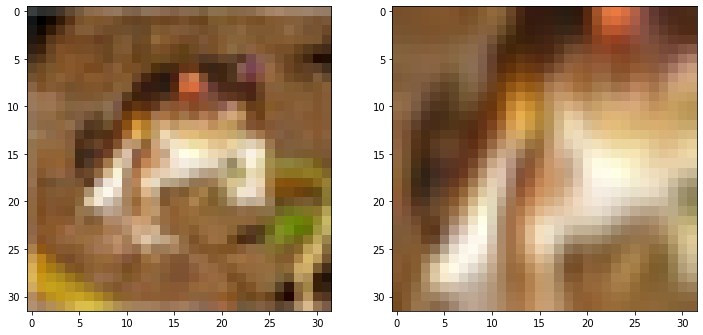

In [22]:
print(X_train.shape)
global_figure = plt.figure(figsize=(12,6))
Ax1 = global_figure.add_subplot(121)
Ax1.imshow(X_train[0, :, :, :])
Ax2 = global_figure.add_subplot(122)
Ax2.imshow( image_echelle(X_train[0, :, :, :], 0.7));

### Translation

In [0]:
def image_translation(img, factor):
    
    # Préparation
    a = e = 1
    b = d = 0

    largeur, hauteur, canaux = img.shape
    c= np.random.randint( -int( largeur * factor ), int( largeur * factor ) )
    f= np.random.randint( -int( hauteur * factor ), int( hauteur * factor ) )
    
    # Tranlsation
    IM = Image.fromarray(img)
    IM = IM.transform(IM.size, Image.AFFINE, (a, b, c, d, e, f))
    
    return np.array(IM)

(50000, 32, 32, 3)


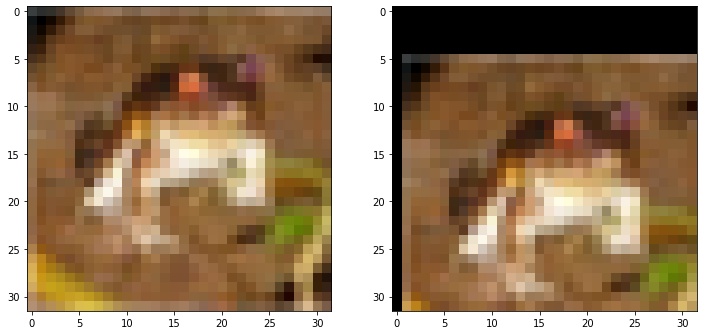

In [24]:
hF = plt.figure(figsize=(12,6))
Ax1 = hF.add_subplot(121)
Ax1.imshow(X_train[0, :, :, :])
Ax2 = hF.add_subplot(122)
Ax2.imshow( image_translation(X_train[0, :, :, :], 0.2))
print(X_train.shape);

### Rotation

In [0]:
def image_rotation(img, angle):
    
    # Préparation
    IM = Image.fromarray(img)
    IM = IM.rotate(angle)
    
    return np.array(IM)

(50000, 32, 32, 3)


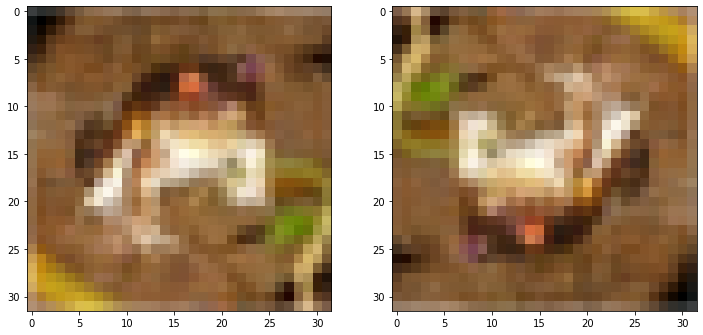

In [26]:
hF = plt.figure(figsize=(12,6))
Ax1 = hF.add_subplot(121)
Ax1.imshow(X_train[0, :, :, :])
Ax2 = hF.add_subplot(122)
Ax2.imshow( image_rotation(X_train[0, :, :, :], 180))
print(X_train.shape);

### Inversion

In [0]:
def image_inversion(img, proba_h, proba_v):
    
    # Préparation
    if proba_h > np.random.random():
        if proba_v > np.random.random():
            img = img[::-1, ::-1, :]
        else:
            img = img[:, ::-1, :]
    else:
        img = img[::-1, :, :]
    
    return np.array(img)

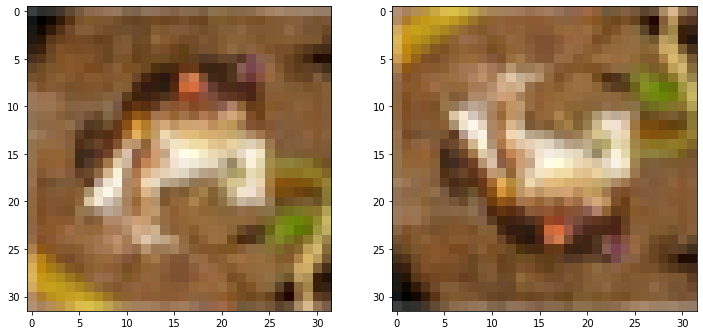

In [28]:
X_train.shape
hF = plt.figure(figsize=(12,6))
Ax1 = hF.add_subplot(121)
Ax1.imshow(X_train[0, :, :, :])
Ax2 = hF.add_subplot(122)
Ax2.imshow( image_inversion(X_train[0, :, :, :], 0, 0));

## Partie 3: Construction du réseau

In [29]:
vec_permutation = np.random.permutation(50000)
vec_permutation

array([41598, 24565, 49644, ..., 31857,  9474,  8209])

### Preprocessing

In [30]:
X_train.shape # 50000 images, 3 color channels

(50000, 32, 32, 3)

In [31]:
X_train[0].shape

(32, 32, 3)

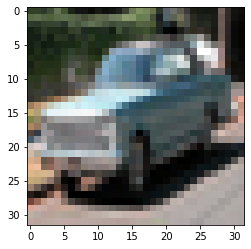

In [32]:
plt.imshow(X_train[32]);

In [33]:
X_train.max()

255

In [0]:
# Normalization

X_train = X_train / X_train.max()
X_test = X_test /X_test.max()

In [35]:
X_train.shape

(50000, 32, 32, 3)

In [36]:
Y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [0]:
# One-hot encoding with the help of "to_categorical" utility:

from keras.utils.np_utils import to_categorical

In [0]:
Y_categorical_test = to_categorical(Y_test, 10)
Y_categorical_train = to_categorical(Y_train, 10)

In [39]:
Y_categorical_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

### Construction de réseau

In [0]:
model = tf.keras.models.Sequential()

In [41]:
## FIRST SET OF LAYERS

# CONVOLUTIONAL LAYER
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4),input_shape=(32, 32, 3), activation='relu',))
# CONVOLUTIONAL LAYER
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4),input_shape=(32, 32, 3), activation='relu',))

# POOLING LAYER
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

## SECOND SET OF LAYERS

# CONVOLUTIONAL LAYER
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4),input_shape=(32, 32, 3), activation='relu',))
# CONVOLUTIONAL LAYER
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4),input_shape=(32, 32, 3), activation='relu',))

# POOLING LAYER
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

# FLATTEN IMAGES FROM 32 by 32 by 3 to 3072 BEFORE FINAL LAYER
model.add(tf.keras.layers.Flatten())

# 512 NEURONS IN DENSE HIDDEN LAYER (6 times inside 3072, but the number can be changed)
model.add(tf.keras.layers.Dense(512, activation='relu'))

# LAST LAYER IS THE CLASSIFIER, THUS 10 POSSIBLE CLASSES
model.add(tf.keras.layers.Dense(10, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 29, 29, 32)        1568      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        16416     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0

## Partie 4: Définition de la tâche facile

### Désolée, Younes, je ne comprends pas les méthodes facile - difficile...... Je viens de faire l'entraînement NN avec Keras. 

In [0]:
vec_permutation = np.random.permutation(50000)
X_train_perm = X_train[vec_permutation, :, :, :]
Y_train_perm = Y_train[vec_permutation]

batch = X_train_perm[:100]

for i_ in batch:
    # coef_tr = np.random.rand()
    # image = image_translation(i_, coef_tr)
    image = image_translation(i_, 10)



## Partie 5: Définition de la tâche difficile

## Partie 6: Entrainement et monitoring de l'erreur de test

In [43]:
model.fit(X_train,Y_categorical_train,verbose=1,epochs=20)

Train on 50000 samples
Epoch 1/20
50000/50000 [==============================] - 13s 270us/sample - loss: 1.5818 - acc: 0.4297
Epoch 2/20
50000/50000 [==============================] - 9s 189us/sample - loss: 1.1518 - acc: 0.5969
Epoch 3/20
50000/50000 [==============================] - 10s 193us/sample - loss: 0.9970 - acc: 0.6556
Epoch 4/20
50000/50000 [==============================] - 9s 190us/sample - loss: 0.9312 - acc: 0.6822
Epoch 5/20
50000/50000 [==============================] - 10s 192us/sample - loss: 0.8973 - acc: 0.6974
Epoch 6/20
50000/50000 [==============================] - 9s 189us/sample - loss: 0.8886 - acc: 0.7018
Epoch 7/20
50000/50000 [==============================] - 9s 190us/sample - loss: 0.8729 - acc: 0.7081
Epoch 8/20
50000/50000 [==============================] - 10s 190us/sample - loss: 0.8687 - acc: 0.7089
Epoch 9/20
50000/50000 [==============================] - 9s 187us/sample - loss: 0.8665 - acc: 0.7147
Epoch 10/20
50000/50000 [=====================

In [0]:
from sklearn.metrics import classification_report

In [0]:
predictions = model.predict_classes(X_test)

In [48]:
print(classification_report(Y_test,predictions))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71      1000
           1       0.63      0.93      0.75      1000
           2       0.64      0.52      0.58      1000
           3       0.65      0.37      0.47      1000
           4       0.63      0.71      0.66      1000
           5       0.65      0.67      0.66      1000
           6       0.80      0.77      0.79      1000
           7       0.72      0.76      0.74      1000
           8       0.69      0.88      0.77      1000
           9       0.84      0.65      0.73      1000

    accuracy                           0.69     10000
   macro avg       0.70      0.69      0.69     10000
weighted avg       0.70      0.69      0.69     10000

